In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# ========================
# STEP 0: GLOBAL SETUP
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                            precision_score, recall_score, confusion_matrix,
                            roc_curve, precision_recall_curve)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier, VotingClassifier)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from scipy.stats import wasserstein_distance
from statsmodels.stats.contingency_tables import mcnemar
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import time
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [16]:
# ========================
# STEP 1: DATA LOADING & SPLIT
# ========================
# Load data
data = pd.read_csv('/content/drive/MyDrive/ML Projects/Parkinsson disease.csv')
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
data.drop('name', axis=1, inplace=True)

# Initial split (20% test)
X = data.drop("status", axis=1)
y = data["status"]
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

In [6]:
# ========================
# STEP 2: PREPROCESSING (TRAIN ONLY)
# ========================
# Impute missing values
X_train_raw = X_train_raw.fillna(X_train_raw.mean())

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)

# Apply to test set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

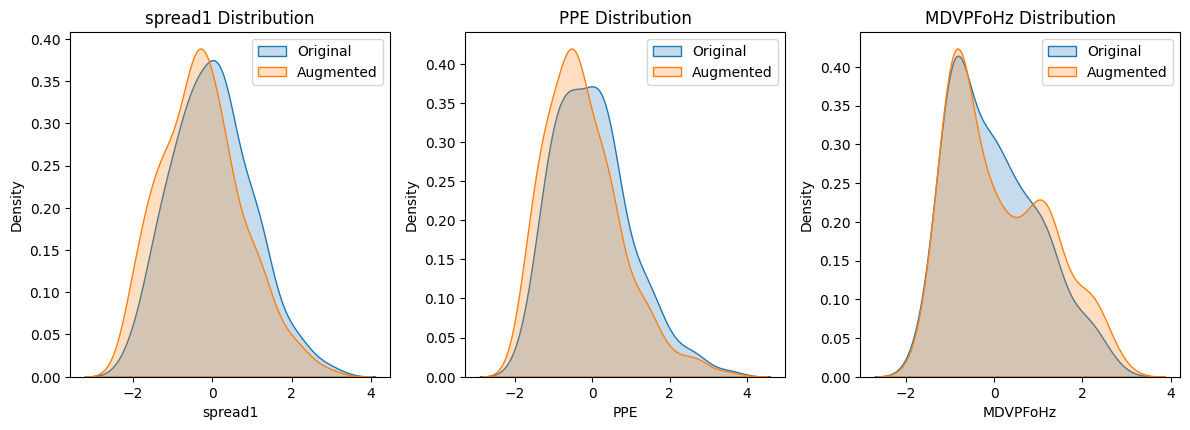


Wasserstein Distance (Original vs Augmented):
spread1: 0.260373
PPE: 0.245858
MDVPFoHz: 0.130170


In [17]:
# ========================
# STEP 3: CLASS BALANCING & AUGMENTATION (FIXED)
# ========================
# Apply SMOTE to training data
smote = SMOTE(sampling_strategy=0.8, random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train_raw)

# Gaussian noise augmentation
noise = np.random.normal(0, 0.05, X_train_res.shape)
X_train_aug = X_train_res + noise
y_train_aug = y_train_res.copy()

# Convert back to DataFrame for easier handling
X_train_aug_df = pd.DataFrame(X_train_aug, columns=X_train_scaled.columns)

# Visualization: Original vs Augmented Distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(['spread1', 'PPE', 'MDVPFoHz'], 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(X_train_scaled[col], label='Original', fill=True)
    sns.kdeplot(X_train_aug_df[col], label='Augmented', fill=True)
    plt.title(f'{col} Distribution')
    plt.legend()
plt.tight_layout()
plt.savefig('augmentation_distributions.png', dpi=300)
plt.show()

# Quantitative validation of augmentation
print("\nWasserstein Distance (Original vs Augmented):")
for col in ['spread1', 'PPE', 'MDVPFoHz']:
    w_dist = wasserstein_distance(X_train_scaled[col], X_train_aug_df[col])
    print(f"{col}: {w_dist:.6f}")

Selected Features: ['MDVPFoHz', 'MDVPFhiHz', 'MDVPFloHz', 'MDVPRAP', 'JitterDDP', 'ShimmerAPQ5', 'MDVPAPQ', 'ShimmerDDA', 'NHR', 'spread1', 'D2', 'PPE']


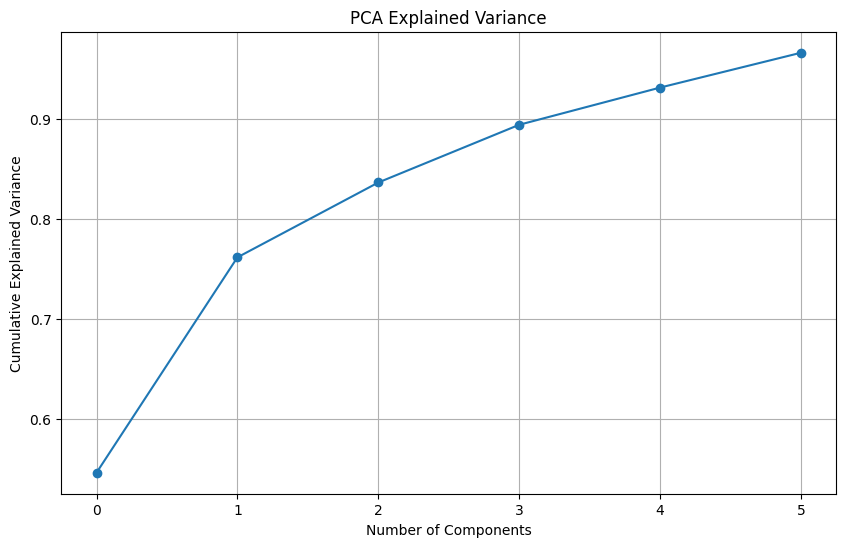

In [18]:
# ========================
# STEP 4: FEATURE ENGINEERING
# ========================
# Feature selection using RFE
selector = RFE(RandomForestClassifier(random_state=SEED),
               n_features_to_select=12, step=1)
selector.fit(X_train_aug, y_train_aug)
X_train_selected = selector.transform(X_train_aug)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_res.columns[selector.support_].tolist()
print(f"Selected Features: {selected_features}")

# PCA (95% variance)
pca = PCA(n_components=0.95, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Visualization: PCA Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.savefig('pca_variance.png', dpi=300)
plt.show()

In [21]:
# ========================
# STEP 5: MODEL TRAINING (FIXED)
# ========================
from xgboost import XGBClassifier
from tensorflow.keras.layers import GlobalMaxPooling1D

# Revised 1D CNN for tabular data
def build_1d_cnn(input_shape):
    model = Sequential()

    # Adjust kernel size based on input dimensions
    kernel_size = min(3, input_shape)

    # First convolutional block
    model.add(Conv1D(32, kernel_size, activation='relu',
                     padding='same',
                     input_shape=(input_shape, 1)))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    # Second convolutional block (only if enough dimensions)
    if input_shape > 3:
        model.add(Conv1D(64, min(3, input_shape//2), activation='relu', padding='same'))
        model.add(MaxPooling1D(2))

    # Final layers
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Reshape for 1D CNN
X_train_cnn = X_train_pca.reshape(X_train_pca.shape[0], X_train_pca.shape[1], 1)
X_test_cnn = X_test_pca.reshape(X_test_pca.shape[0], X_test_pca.shape[1], 1)

# Print PCA dimensions for debugging
print(f"PCA dimensions - Train: {X_train_pca.shape}, Test: {X_test_pca.shape}")
print(f"CNN input shape: {X_train_cnn.shape[1:]}")

# Traditional models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=SEED),
    "SVM": SVC(probability=True, random_state=SEED),
    "RandomForest": RandomForestClassifier(random_state=SEED),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=SEED),
    "GradientBoosting": GradientBoostingClassifier(random_state=SEED),
    "AdaBoost": AdaBoostClassifier(random_state=SEED),
    "1D_CNN": build_1d_cnn(X_train_pca.shape[1])
}

# Hyperparameter grids
param_grids = {
    "LogisticRegression": {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
    "SVM": {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']},
    "RandomForest": {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    "KNN": {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    "XGBoost": {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    "GradientBoosting": {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    "AdaBoost": {'n_estimators': [50, 100], 'learning_rate': [0.5, 1.0]}
}

# Model training function
def train_model(model, X_train, y_train):
    if model == "1D_CNN":
        history = models["1D_CNN"].fit(
            X_train_cnn, y_train_aug,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )
        return models["1D_CNN"], history
    else:
        clf = RandomizedSearchCV(
            models[model],
            param_grids[model],
            n_iter=10,
            cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
            scoring='f1',
            n_jobs=-1,
            random_state=SEED
        )
        clf.fit(X_train, y_train)
        return clf.best_estimator_, clf.best_params_

# Train all models
trained_models = {}
training_histories = {}
for name in models:
    if name != "1D_CNN":
        model, params = train_model(name, X_train_pca, y_train_aug)
        trained_models[name] = model
        print(f"{name} best params: {params}")
    else:
        model, history = train_model(name, None, None)
        trained_models[name] = model
        training_histories[name] = history

# Soft Voting Ensemble
voting = VotingClassifier(
    estimators=[(name, model) for name, model in trained_models.items()
               if name != "1D_CNN"],
    voting='soft'
)
voting.fit(X_train_pca, y_train_aug)
trained_models["SoftVoting"] = voting

PCA dimensions - Train: (212, 6), Test: (39, 6)
CNN input shape: (6, 1)
LogisticRegression best params: {'solver': 'lbfgs', 'C': 0.1}
SVM best params: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
RandomForest best params: {'n_estimators': 100, 'max_depth': None}
KNN best params: {'weights': 'distance', 'n_neighbors': 3}
XGBoost best params: {'max_depth': 5, 'learning_rate': 0.1}
GradientBoosting best params: {'n_estimators': 200, 'learning_rate': 0.1}
AdaBoost best params: {'n_estimators': 100, 'learning_rate': 0.5}


In [22]:
# ========================
# STEP 6: EVALUATION METRICS
# ========================
def bootstrap_ci(y_true, y_pred, metric_func, n_bootstraps=1000, ci=95):
    scores = []
    n = len(y_true)
    alpha = (100 - ci) / 200
    for _ in range(n_bootstraps):
        indices = np.random.choice(n, n, replace=True)
        score = metric_func(y_true.iloc[indices], y_pred[indices])
        scores.append(score)
    lower = np.percentile(scores, 100 * alpha)
    upper = np.percentile(scores, 100 * (1 - alpha))
    return (lower, upper)

def evaluate_model(model, X_test, y_test, name):
    start_time = time.time()

    # Handle CNN separately
    if name == "1D_CNN":
        y_prob = model.predict(X_test_cnn).flatten()
        y_pred = (y_prob > 0.5).astype(int)
    elif name == "SoftVoting":
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    inference_time = time.time() - start_time

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob),
        'Inference Time': inference_time
    }

    # Bootstrap CIs
    metrics['Accuracy CI'] = bootstrap_ci(y_test, y_pred, accuracy_score)
    metrics['F1 CI'] = bootstrap_ci(y_test, y_pred, f1_score)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    return metrics, cm, fpr, tpr, y_prob


In [23]:
# ========================
# STEP 7: COMPREHENSIVE EVALUATION
# ========================
# Evaluate all models
results = {}
confusion_matrices = {}
roc_data = {}
y_probs = {}

for name, model in trained_models.items():
    if name == "1D_CNN":
        test_data = X_test_cnn
    else:
        test_data = X_test_pca

    metrics, cm, fpr, tpr, y_prob = evaluate_model(
        model, test_data, y_test, name
    )

    results[name] = metrics
    confusion_matrices[name] = cm
    roc_data[name] = (fpr, tpr)
    y_probs[name] = y_prob

# McNemar's test between best model and others
best_model = max(results, key=lambda k: results[k]['F1'])
print(f"\nBest Model: {best_model} (F1={results[best_model]['F1']:.4f})")

mcnemar_results = {}
for name in results:
    if name != best_model:
        # Create contingency table
        y_pred_best = (y_probs[best_model] > 0.5).astype(int)
        y_pred_other = (y_probs[name] > 0.5).astype(int)

        a = np.sum((y_pred_best == y_test) & (y_pred_other == y_test))
        b = np.sum((y_pred_best == y_test) & (y_pred_other != y_test))
        c = np.sum((y_pred_best != y_test) & (y_pred_other == y_test))
        d = np.sum((y_pred_best != y_test) & (y_pred_other != y_test))

        table = [[a, b], [c, d]]
        result = mcnemar(table, exact=True)
        mcnemar_results[f"{best_model} vs {name}"] = result.pvalue

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Best Model: XGBoost (F1=0.9455)


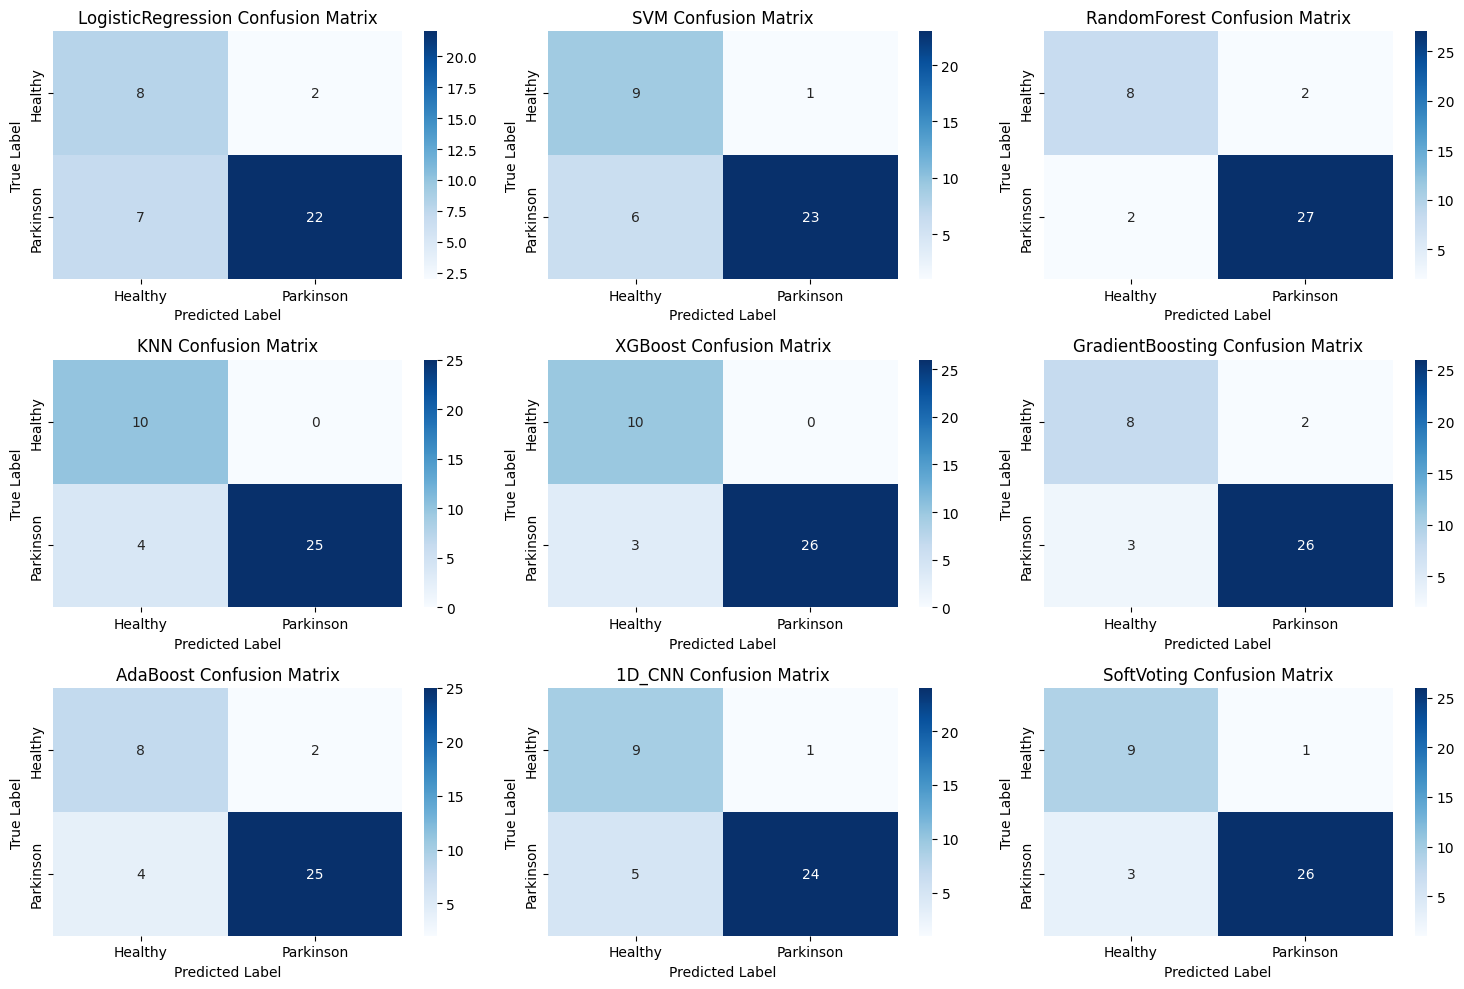

In [24]:
# ========================
# STEP 8: VISUALIZATIONS
# ========================
# 1. Confusion Matrix Visualization
plt.figure(figsize=(15, 10))
for i, (name, cm) in enumerate(confusion_matrices.items(), 1):
    plt.subplot(3, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'Parkinson'],
                yticklabels=['Healthy', 'Parkinson'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()


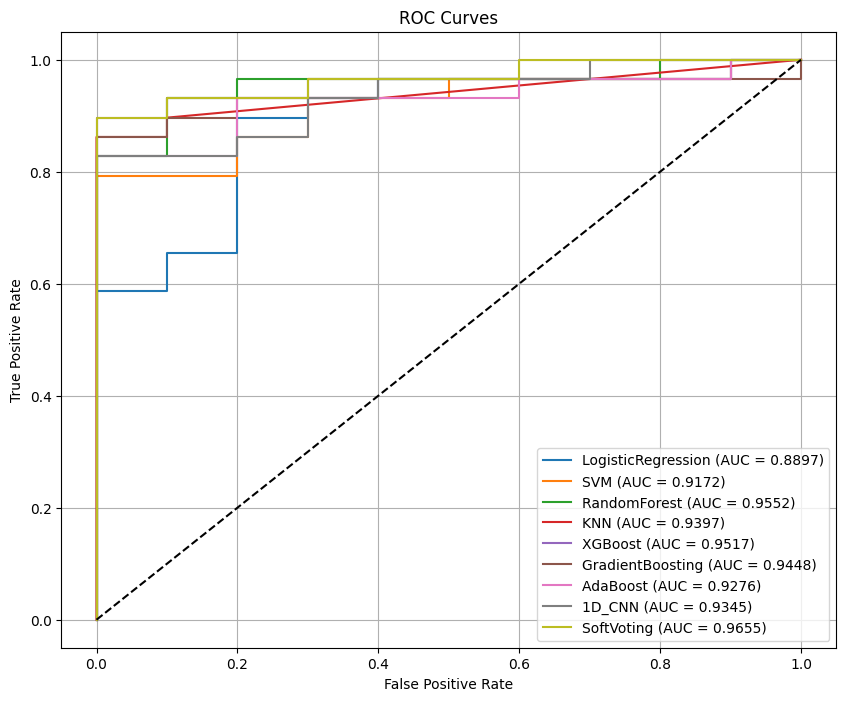

In [25]:
# 2. ROC Curve Comparison
plt.figure(figsize=(10, 8))
for name, (fpr, tpr) in roc_data.items():
    auc = roc_auc_score(y_test, y_probs[name])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curves.png', dpi=300)
plt.show()

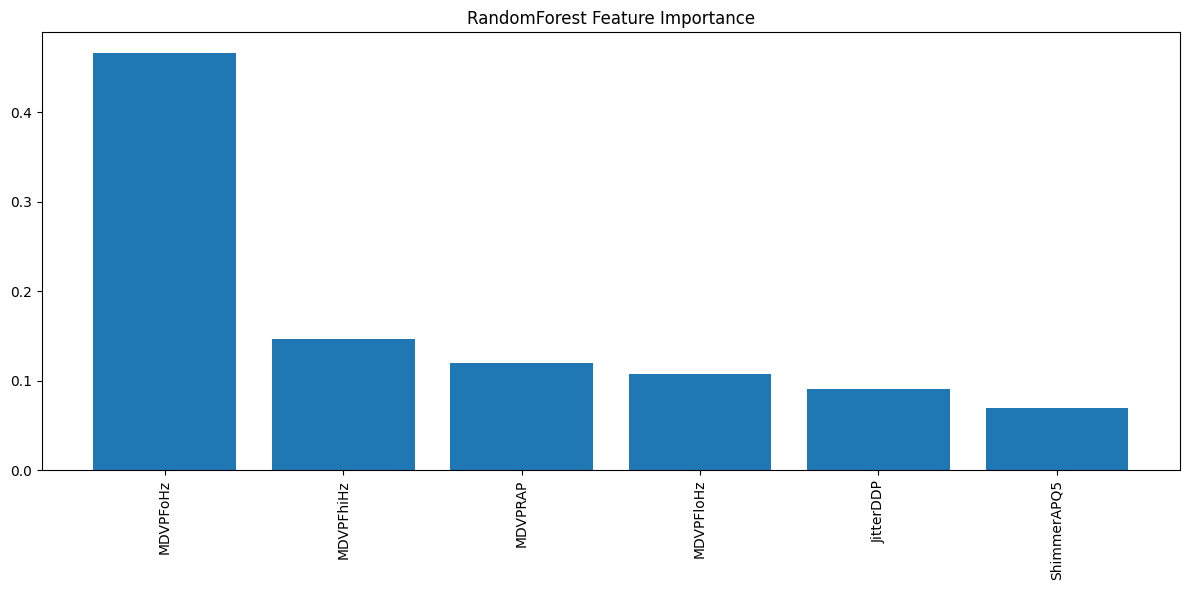

In [26]:
# 3. Feature Importance
rf = trained_models["RandomForest"]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("RandomForest Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [selected_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

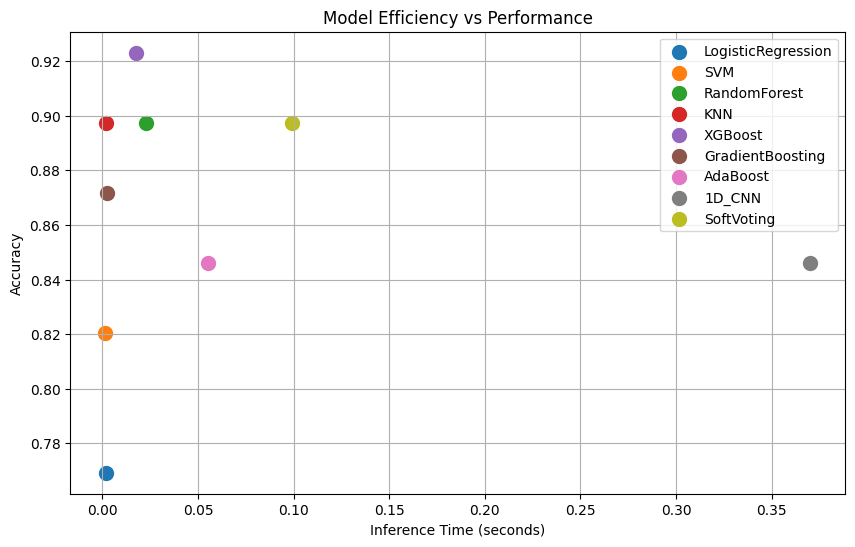

In [27]:
# 4. Inference Time vs Accuracy
plt.figure(figsize=(10, 6))
for name in results:
    plt.scatter(
        results[name]['Inference Time'],
        results[name]['Accuracy'],
        s=100,
        label=name
    )
plt.xlabel('Inference Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Model Efficiency vs Performance')
plt.legend()
plt.grid(True)
plt.savefig('efficiency_vs_performance.png', dpi=300)
plt.show()

In [28]:
# ========================
# STEP 9: RESULTS REPORTING
# ========================
# Print metrics
print("\n===== Model Performance Metrics =====")
metrics_df = pd.DataFrame(results).T
print(metrics_df[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']])

print("\n===== Bootstrap Confidence Intervals =====")
print(metrics_df[['Accuracy CI', 'F1 CI']])

print("\n===== McNemar Test Results =====")
for comparison, pval in mcnemar_results.items():
    print(f"{comparison}: p = {pval:.6f}")

# Save results for paper
metrics_df.to_csv('model_performance.csv')


===== Model Performance Metrics =====
                    Accuracy Precision    Recall        F1   AUC-ROC
LogisticRegression  0.769231  0.916667  0.758621  0.830189  0.889655
SVM                 0.820513  0.958333  0.793103  0.867925  0.917241
RandomForest        0.897436  0.931034  0.931034  0.931034  0.955172
KNN                 0.897436       1.0  0.862069  0.925926  0.939655
XGBoost             0.923077       1.0  0.896552  0.945455  0.951724
GradientBoosting    0.871795  0.928571  0.896552  0.912281  0.944828
AdaBoost            0.846154  0.925926  0.862069  0.892857  0.927586
1D_CNN              0.846154      0.96  0.827586  0.888889  0.934483
SoftVoting          0.897436  0.962963  0.896552  0.928571  0.965517

===== Bootstrap Confidence Intervals =====
                                                 Accuracy CI  \
LogisticRegression  (0.6153846153846154, 0.8974358974358975)   
SVM                 (0.6923076923076923, 0.9230769230769231)   
RandomForest        (0.794871794871